In [31]:
import pandas as pd
import numpy as np
from scipy.stats import gamma,norm
from datetime import datetime
import matplotlib.pyplot as plt

In [32]:
start_yr=int(input("please enter start year: "))
start_mon=int(input("please enter start month: "))
end_yr=int(input("please enter end year: "))
end_mon=int(input("please enter end month: "))
SPI_num=int(input("please enter the SPI type (1-12): "))

start_date = datetime(start_yr,start_mon,1)
end_date = datetime(end_yr,end_mon,1)


In [33]:
df = pd.read_csv('./godavari_basins/ethurunagaram.csv')

df['Dates'] = pd.to_datetime(df['Dates'])
df['Month'] = df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year

filtered_df = df[(df['Dates'] >= start_date) & (df['Dates'] <= end_date)]
filtered_dates=filtered_df['Dates']
filtered_dates=filtered_dates[SPI_num-1:]

date_objects = pd.to_datetime(filtered_dates)
date_objects = [date.strftime('%b-%Y') for date in date_objects]

rainfall_data = filtered_df['ACTUAL (mm) '].to_numpy()
rainfall_data = np.convolve(rainfall_data, np.ones(SPI_num)/SPI_num, mode='valid')

process_data = pd.to_numeric(rainfall_data, errors='coerce')
process_data[process_data == 0] = 1e-15
process_data = np.array(process_data)
process_data = process_data[~np.isnan(process_data)]

params = gamma.fit(process_data,floc=0)
shape, loc, scale = params

spi_vals = norm.ppf(gamma.cdf(process_data, shape, loc=0, scale=scale))
print(spi_vals)



[-2.61424485e-01 -1.83818920e-01  4.07112086e-01  6.42563582e-01
  8.24748783e-01  9.63696130e-01  8.44796321e-01  6.22992396e-01
  3.74961241e-01 -6.71183443e-02 -4.38412360e+00 -5.27424044e-01
 -5.27424044e-01 -5.27424044e-01  1.26462860e-01  3.75168674e-01
  6.10445463e-01  6.76986878e-01  6.34837569e-01  4.55260661e-01
  1.34955055e-01 -4.47049594e-02 -4.38412360e+00 -4.38412360e+00
 -6.52805810e-01 -4.28985823e-01  1.89356937e-01  5.32313100e-01
  8.71966052e-01  9.29104607e-01  8.10707298e-01  5.98882422e-01
  8.50471994e-02 -1.47785616e-01 -2.01109564e-01 -2.01109564e-01
 -3.72968203e-01 -6.04610640e-01 -6.04610640e-01  2.79199212e-01
  7.28684976e-01  8.16327757e-01  9.42769688e-01  7.64694109e-01
  3.22921585e-01  3.46950477e-01  7.64766826e-04 -2.86150946e-04
  3.75376037e-01  2.05711712e-01  4.86306534e-01  7.67782843e-01
  1.32697470e+00  1.40554801e+00  1.53176223e+00  1.48350517e+00
  8.84884796e-01  7.39819859e-01  1.30325979e-01 -9.91029495e-01
  8.57991054e-01  1.29136

/tmp/ipykernel_23994/2206369594.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


In [34]:
spi_mean=np.mean(spi_vals)

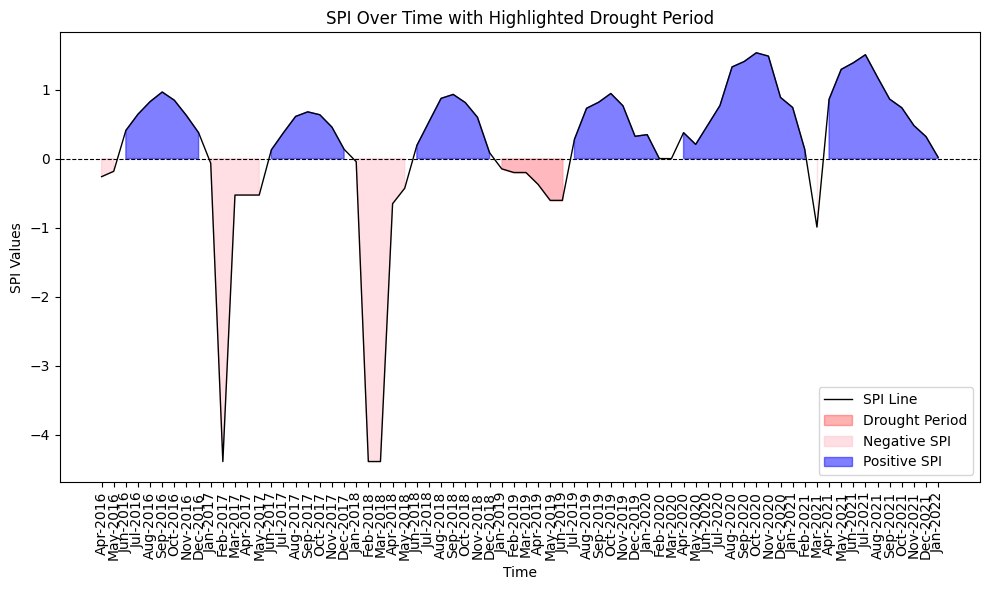

In [35]:
def find_drought_period_indices(spi_values):
    drought_periods = []
    current_drought_period = []

    for i, spi in enumerate(spi_values):
        if spi < 0:
            current_drought_period.append(i)
        elif current_drought_period:
            drought_periods.append(current_drought_period)
            current_drought_period = []

    if current_drought_period:
        drought_periods.append(current_drought_period)

    longest_drought_period_indices = max(drought_periods, key=len)
    return longest_drought_period_indices

def plot_spi_with_drought_highlighted(spi_values):
    indices = np.arange(len(spi_values))
    longest_drought_period_indices = find_drought_period_indices(spi_values)

    plt.figure(figsize=(10, 6))
    plt.plot(date_objects, spi_values, color='black', label='SPI Line', linewidth=1)
    
    if longest_drought_period_indices:
        start_index = longest_drought_period_indices[0]
        end_index = longest_drought_period_indices[-1]
        plt.fill_between(date_objects[start_index:end_index+1], spi_values[start_index:end_index+1],
                         color='red', alpha=0.3, label='Drought Period')
        
    plt.fill_between(date_objects, spi_values, where=(spi_values <0), color='pink', alpha=0.5, label='Negative SPI')
    plt.fill_between(date_objects, spi_values, where=(spi_values >0), color='blue', alpha=0.5, label='Positive SPI')

    plt.xlabel('Time')
    plt.ylabel('SPI Values')
    plt.title('SPI Over Time with Highlighted Drought Period')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    plt.xticks(date_objects, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_spi_with_drought_highlighted(spi_vals)


In [56]:
print(find_drought_period_indices(spi_vals))

[33, 34, 35, 36, 37, 38]


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


def find_drought_periods_indices(spi_values):
    drought_periods = []
    current_drought_period = []

    for i, spi in enumerate(spi_values):
        if spi < 0:
            current_drought_period.append(i)
        elif current_drought_period:
            drought_periods.append(current_drought_period)
            current_drought_period = []

    if current_drought_period:
        drought_periods.append(current_drought_period)

    return drought_periods

def calculate_drought_intensity(spi_values, drought_periods_indices):
    intensities = []
    for period_indices in drought_periods_indices:
        min_spi = min(spi_values[period_indices])
        intensities.append(min_spi)
    return intensities

def calculate_drought_duration(drought_periods_indices):
    durations = [len(period_indices) for period_indices in drought_periods_indices]
    return durations



def calculate_drought_frequency(drought_periods_indices):
    return len(drought_periods_indices)


try1=[]
try1=find_drought_periods_indices(spi_vals)
intensity=[]
intensity=calculate_drought_intensity(spi_vals,try1)
duration=[]
duration=calculate_drought_duration(try1)

frequency=[]
frequency=calculate_drought_frequency(try1)

In [51]:
print("Drought Frequency: ", frequency)

Drought Frequency:  6


In [52]:
print("Drought Periods Indices: ", try1)

Drought Periods Indices:  [[0, 1], [9, 10, 11, 12, 13], [21, 22, 23, 24, 25], [33, 34, 35, 36, 37, 38], [47], [59]]


In [53]:
print("Drought Intensity: ", intensity)

Drought Intensity:  [-0.26142448451204353, -4.384123598378369, -4.384123598378369, -0.6046106399533558, -0.00028615094575896793, -0.9910294945360222]


In [54]:
print("Drought Period duration: " , duration)

Drought Period duration:  [2, 5, 5, 6, 1, 1]


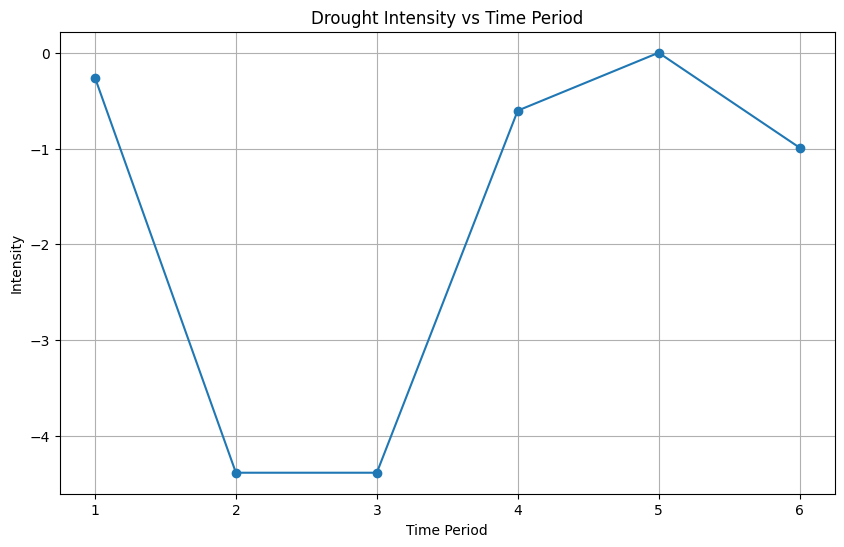

In [60]:
intensity_data = intensity
time_period = np.arange(1, len(intensity_data) + 1)

# Plot the intensity vs time period
plt.figure(figsize=(10, 6))
plt.plot(time_period, intensity_data, marker='o', linestyle='-')
plt.xlabel('Time Period')
plt.ylabel('Intensity')
plt.title('Drought Intensity vs Time Period')
plt.grid(True)
plt.xticks(time_period)
plt.show()

In [61]:
drought_durations = duration
plt.figure(figsize=(10, 6))
plt.hist(drought_durations, bins=range(min(drought_durations), max(drought_durations) + 1), edgecolor='black')
plt.xlabel('Drought Duration (Months)')
plt.ylabel('Frequency')
plt.title('Histogram of Drought Durations')
plt.grid(True)
plt.xticks(np.arange(min(drought_durations), max(drought_durations) + 1, 1))
plt.show()


TypeError: 'int' object is not iterable

<Figure size 1000x600 with 0 Axes>

Calculating Spatial Data by reading CSV

In [ ]:
# calculate spatial data by reading csv

df = pd.read_csv('./godavari_basins/ethurunagaram.csv')

df['Dates'] = pd.to_datetime(df['Dates'])
df['Month'] = df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year



In [ ]:
def calculate_spatial_extent(drought_periods_indices, spatial_data):
    polygons = [Polygon(spatial_data[period_indices]) for period_indices in drought_periods_indices]
    total_area = sum(polygon.area for polygon in polygons)
    return total_area

spatial_interpolation=[]
spatial_interpolation=calculate_spatial_extent(try1,spi_vals)